The aim of this notebook is to setup a simple sequence to test the effect of one single beam-beam encounter.
It is a very interesting exercise to see the convention and the logic used in MADX.

In [1]:
pwd

'/afs/cern.ch/user/a/apoyet'

In [2]:
!which python

/cvmfs/sft.cern.ch/lcg/views/LCG_96python3/x86_64-centos7-gcc8-opt/bin/python


In [3]:
from cpymad.madx import Madx
import numpy as np
from cl2pd import particle
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
%config InlineBackend.figure_format = 'retina' # retina display

# Functions
---
For convenience

In [4]:
# https://www.overleaf.com/2212514949wpzxkswydwcb (please put Werner or similar)
def BBKick(x,Np,gamma_r, sigma):
    r_p=1.53e-18
    if x==0:
        return(0)
    else:
        return 2*r_p*Np/gamma_r/x*(1-np.exp(-x**2/(2*sigma**2)))

BBKickVector=np.vectorize(BBKick)

def trackIt(onepass='false', plotAnalytical=True):
    points=51
    x_range= np.linspace(-.002,.002,points)
    myString=f'track, onepass={onepass};\n'
    for myX in x_range:
        myString+=f'''start,x={myX};\n'''
    myString+='observe, place=myBB1;run, turns=1; endtrack;\n'
    madx.input(myString)
    plt.plot(x_range*1000,[madx.table[i].dframe()['px'].values[0]*1e6 for i in list(madx.table)[(3+points):]],'ob', label='Numerical')
    if plotAnalytical:
        plt.plot(x_range*1000,BBKickVector(x_range, npart, gamma, sigma_x)*1e6,'r',label='Analytical reference')
    #aux=plt.ylim()
    #plt.plot([xma*1000, xma*1000],aux)
    #plt.ylim(aux)
    plt.grid(True)
    plt.xlabel('[mm]')
    plt.ylabel('[$\mu$rad]')
    plt.legend(loc='best')
    
def twissDF(col = ['x', 'y', 'px', 'py']):
    display(madx.table.twiss.dframe()[col])

# I - Transfer Line
---

## 1) Effect of a beam-beam element

We start with a simple transfer line, composed of an IP and a beam-beam element. 

In [5]:
madx = Madx()
# all quantities in MADX units
betax_IP=0.25 # beta_x at the IP. The IP is the start of the sequence
betay_IP=0.25 # beta_y at the IP. The IP is the start of the sequence
positionBB=10 # position of the BB and end of the transfer lin
totalEnergy=6500 # beam total energy
emittanceNormalized=3.5e-6 # we assume same h/v normalized emittance
npart=1.15e11 # number of particle in the strong beam
xma=0 # x position of the strong beam center wrt the weak beam reference
yma=0 # y position of the strong beam center wrt the weak beam reference

gamma=particle.setTotalEnergy_GeV(6500)['relativisticGamma']
betagamma=particle.setTotalEnergy_GeV(6500)['relativisticBetaGamma']
betax_BB=betax_IP+positionBB**2/betax_IP # we are in a drift
betay_BB=betax_IP+positionBB**2/betay_IP # we are in a drift
sigma_x=np.sqrt(betax_BB*emittanceNormalized/betagamma) 
sigma_y=np.sqrt(betay_BB*emittanceNormalized/betagamma)

madx.input(
f'''
option,echo=false,warn=false,info=false;
myBB : beambeam, charge=+1, sigx={sigma_x}, sigy={sigma_y}, xma={xma}, yma={yma}, bbshape=1, bbdir=-1;

lhc: sequence, l={positionBB};
myBB1: myBB, at={positionBB};
endsequence;

beam, particle=proton, energy={totalEnergy}, npart={npart};
use, sequence=lhc;

option, bborbit=false;
twiss,betx={betax_IP},bety={betay_IP};
''');


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.11.13 11:24:03      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       0.246021955                  0             400.25                  0 

             dxrms             xcomax             xcorms                 q2 
                 0         

Let's have a look to the twiss we get.

In [6]:
twissDF()

x    y   px   py
#s          0.0  0.0  0.0  0.0
drift_0[0]  0.0  0.0  0.0  0.0
mybb1       0.0  0.0  0.0  0.0
#e          0.0  0.0  0.0  0.0

The TWISS function of MAD-X gives the position and momenta of the particle with respect to the reference orbit. In this particular case, this reference orbit is not affected by the presence of the beam-beam kick. 

enter TRACK module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

Full 6D closed orbit search.
Initial value of 6-D closed orbit from Twiss: 
orbit0   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  Singular matrix occurred during closed orbit search.

6D closed orbit found by subroutine trclor 
iteration:   2 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
exit TRACK module



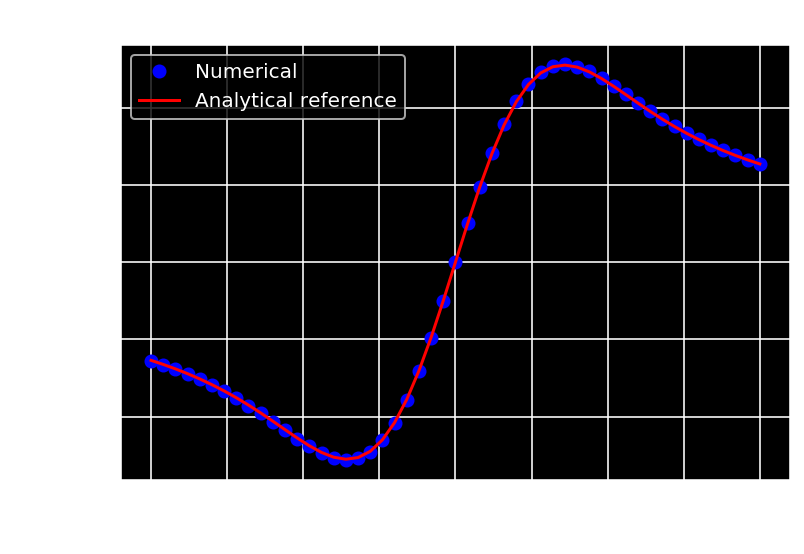

In [9]:
trackIt()
plt.gca().set_title('BB Kick in a simple transfer line');

#plt.savefig('/eos/user/a/apoyet/localMac/PLOTS/bb_effect/simple_transfer_line.png', bbox_inches='tight')

The TRACK function is expressing the positions and kicks with respect to the closed orbit it the *onepass* argument is set to *False* (by default). In this first example, since the *bborbit* flag is set to *False* as well, the dipolar effect of the beam-beam kick on the closed orbit vanishes, and the tracking result correspond to the analytical reference. 

## 2) Beam declaration and beam-beam kick

This section aims to understand the link between the beam declaration and the beam-beam kick. For instance, by not declaring the weak beam intensity, the latter is set to zero and therefore no kick is obviously visible. 


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.11.13 11:27:47      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       0.246021955                  0             400.25                  0 

             dxrms             xcomax             xcorms                 q2 
                 0         

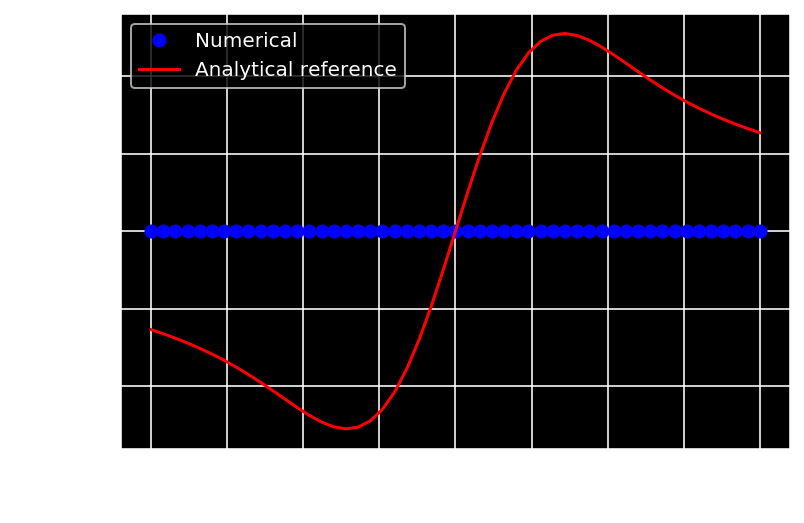

In [10]:
madx = Madx()

madx.input(
f'''
option,echo=false,warn=false,info=false;
myBB : beambeam, charge=+1, sigx={sigma_x}, sigy={sigma_y}, xma={xma}, yma={yma}, bbshape=1, bbdir=-1;

lhc: sequence, l={positionBB};
myBB1: myBB, at={positionBB};
endsequence;

beam, particle=proton, energy={totalEnergy};
use, sequence=lhc;

option, bborbit=false;
twiss,betx={betax_IP},bety={betay_IP};
''');
trackIt()

Modifying the intensity of the declared beam therefore changes the intensity of the weak beam. In order to change virtually the intensity of the strong beam, one can change the charge of the beam-beam element. For instance, if one multiplies it by 2. 

In [11]:
madx = Madx()

madx.input(
f'''
option,echo=false,warn=false,info=false;
myBB : beambeam, charge=+2, sigx={sigma_x}, sigy={sigma_y}, xma={xma}, yma={yma}, bbshape=1, bbdir=-1;

lhc: sequence, l={positionBB};
myBB1: myBB, at={positionBB};
endsequence;

beam, particle=proton, energy={totalEnergy},npart={npart};
use, sequence=lhc;

option, bborbit=false;
twiss,betx={betax_IP},bety={betay_IP};
''');


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.11.13 11:28:00      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       0.246021955                  0             400.25                  0 

             dxrms             xcomax             xcorms                 q2 
                 0         

enter TRACK module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

Full 6D closed orbit search.
Initial value of 6-D closed orbit from Twiss: 
orbit0   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  Singular matrix occurred during closed orbit search.

6D closed orbit found by subroutine trclor 
iteration:   2 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
exit TRACK module



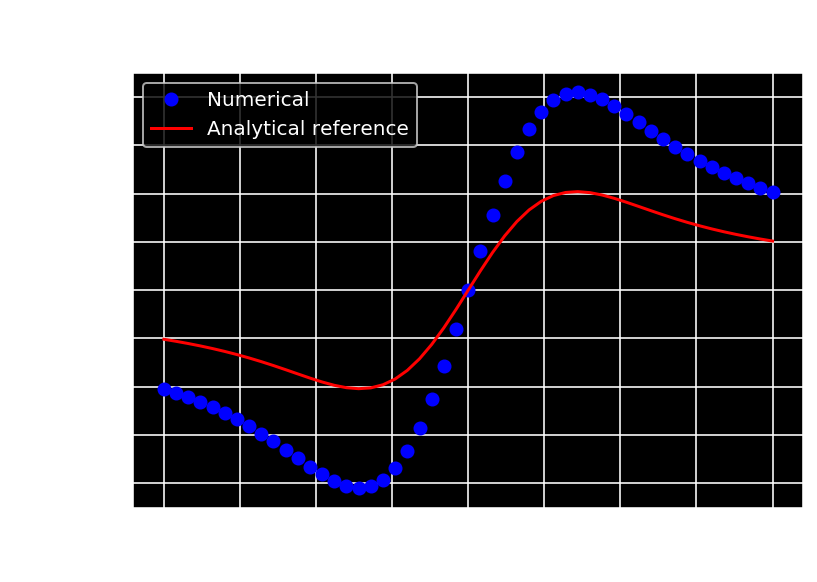

In [12]:
trackIt()
plt.gca().set_title('BB Kick in a simple transfer line\nDouble Beam-Beam Charge');

#plt.savefig('/eos/user/a/apoyet/localMac/PLOTS/bb_effect/simple_transfer_line_double.png', bbox_inches='tight')

The kick is obviously doubled. One can also check that the TWISS table does not change. 

In [13]:
twissDF()

x    y   px   py
#s          0.0  0.0  0.0  0.0
drift_0[0]  0.0  0.0  0.0  0.0
mybb1       0.0  0.0  0.0  0.0
#e          0.0  0.0  0.0  0.0

Obviously, by setting the charge to 0, one switches OFF the BB element. 


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.11.13 11:28:25      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       0.246021955                  0             400.25                  0 

             dxrms             xcomax             xcorms                 q2 
                 0         

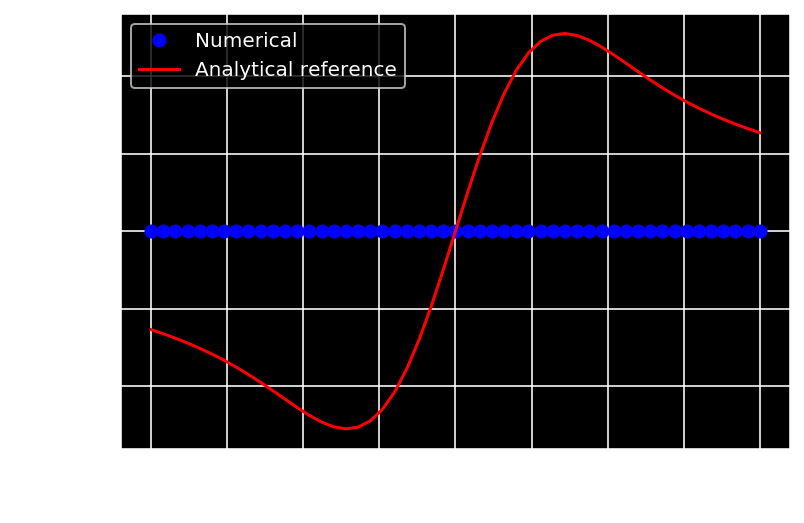

In [14]:
madx = Madx()

madx.input(
f'''
option,echo=false,warn=false,info=false;
myBB : beambeam, charge=0, sigx={sigma_x}, sigy={sigma_y}, xma={xma}, yma={yma}, bbshape=1, bbdir=-1;

lhc: sequence, l={positionBB};
myBB1: myBB, at={positionBB};
endsequence;

beam, particle=proton, energy={totalEnergy},npart={npart};

use, sequence=lhc;

option, bborbit=false;
twiss,betx={betax_IP},bety={betay_IP};
''');
trackIt()

One can also swap the sign of the charge of the BB element. 


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.11.13 11:28:37      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       0.246021955                  0             400.25                  0 

             dxrms             xcomax             xcorms                 q2 
                 0         

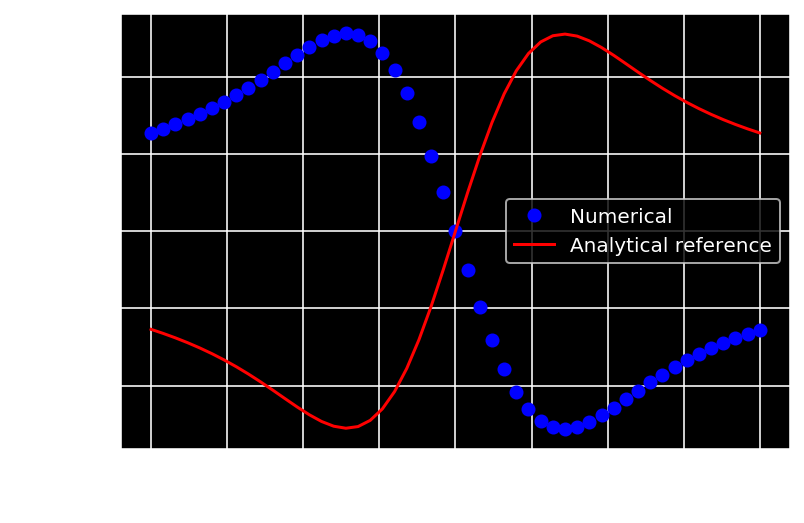

In [15]:
madx = Madx()

madx.input(
f'''
option,echo=false,warn=false,info=false;
myBB : beambeam, charge=-1, sigx={sigma_x}, sigy={sigma_y}, xma={xma}, yma={yma}, bbshape=1, bbdir=-1;

lhc: sequence, l={positionBB};
myBB1: myBB, at={positionBB};
endsequence;

beam, particle=proton, energy={totalEnergy},npart={npart};

use, sequence=lhc;

option, bborbit=false;
twiss,betx={betax_IP},bety={betay_IP};
''');
trackIt()

And the kick is the same, with an opposite sign. 

In the BB element, one argument (*bbdir*) sets the direction of the strong beam. By default, this argument is set to -1: beams move in opposite direction as in a collider. The Lorentz force enhances the BB interactions. If this argument is set to +1, the beams move in the same direction. This is for instance used in the case of an electron cooler. First, let us simply set the *bbdir* to +1, not defining any other beam, and leaving the charge of the BB element to +1. 

In [16]:
madx = Madx()

madx.input(
f'''
option,echo=false,warn=false,info=false;
myBB : beambeam, charge=+1, sigx={sigma_x}, sigy={sigma_y}, xma={xma}, yma={yma}, bbshape=1, bbdir=1;

lhc: sequence, l={positionBB};
myBB1: myBB, at={positionBB};
endsequence;

beam, particle=proton, energy={totalEnergy},npart={npart};
use, sequence=lhc;

option, bborbit=false;
twiss,betx={betax_IP},bety={betay_IP};
''');


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.11.13 11:29:05      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       0.246021955                  0             400.25                  0 

             dxrms             xcomax             xcorms                 q2 
                 0         

enter TRACK module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

Full 6D closed orbit search.
Initial value of 6-D closed orbit from Twiss: 
orbit0   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  Singular matrix occurred during closed orbit search.

6D closed orbit found by subroutine trclor 
iteration:   2 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
exit TRACK module



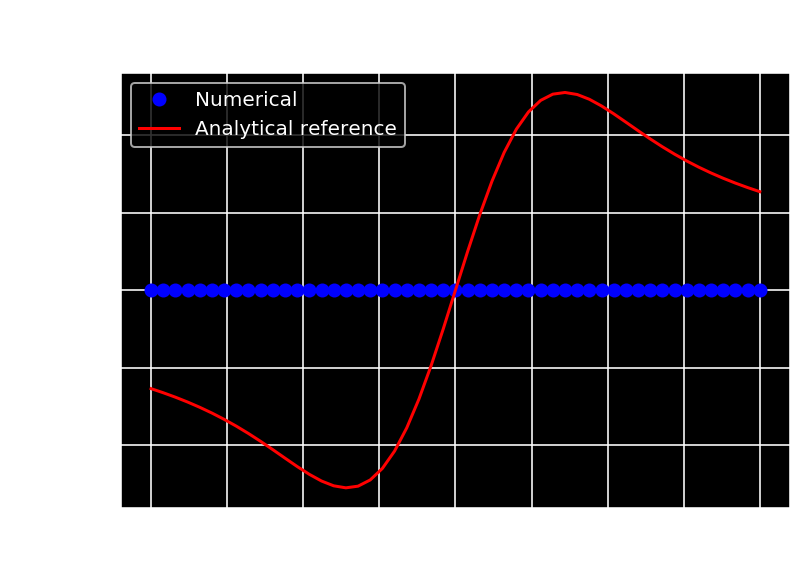

In [17]:
trackIt()
plt.gca().set_title('BB Kick in a simple transfer line\nbbdir = +1');

#plt.savefig('/eos/user/a/apoyet/localMac/PLOTS/bb_effect/simple_transfer_line_bbdir.png', bbox_inches='tight')

The two beams circulate in the same direction, the kick therefore cancels out. By setting the charge of the BB element to -1, the same result is expected and obtained since the two beams are considered to be ultra relativistic. 


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.11.13 11:30:07      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       0.246021955                  0             400.25                  0 

             dxrms             xcomax             xcorms                 q2 
                 0         

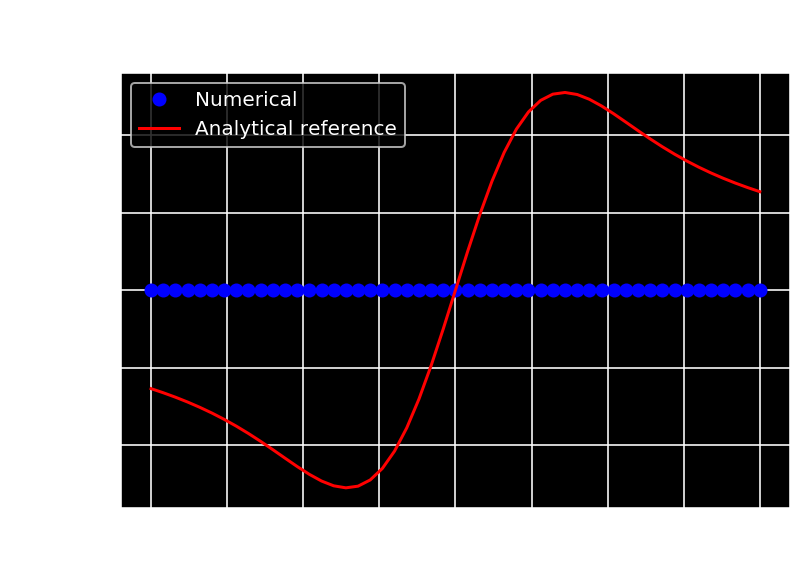

In [18]:
madx = Madx()

madx.input(
f'''
option,echo=false,warn=false,info=false;
myBB : beambeam, charge=-1, sigx={sigma_x}, sigy={sigma_y}, xma={xma}, yma={yma}, bbshape=1, bbdir=1;

lhc: sequence, l={positionBB};
myBB1: myBB, at={positionBB};
endsequence;

beam, particle=proton, energy={totalEnergy},npart={npart};
use, sequence=lhc;

option, bborbit=false;
twiss,betx={betax_IP},bety={betay_IP};
''');

trackIt()
plt.gca().set_title('BB Kick in a simple transfer line\nbbdir = +1, charge = -1');

As expect, the kick cancels out. 

From MAD-X manual, it is important to underline that:
- The BB element assumes a strong beam. Its intensity therefore cannot be changed. The only *trick* is to play with the charge parameter. 
- The energy of the strong beam is assumed to be the same as the unperturbed particles of the weak beam. This feature cannot be modified. 
Clearly, the beam definition in MAD-X correspond to a definition of the weak beam of interest and does not affect the BB element. 

## 3) BB kick and energy

The weak beam energy plays an important role. The BB kick is indeed not normlized to the energy. 


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.11.13 11:30:19      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       0.246021955                  0             400.25                  0 

             dxrms             xcomax             xcorms                 q2 
                 0         

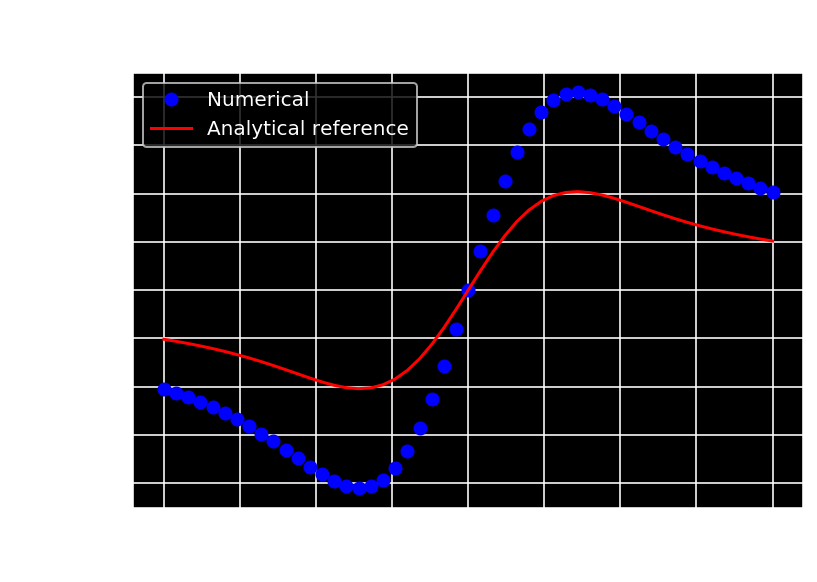

In [19]:
madx = Madx()

madx.input(
f'''
option,echo=false,warn=false,info=false;
myBB : beambeam, charge=1, sigx={sigma_x}, sigy={sigma_y}, xma={xma}, yma={yma}, bbshape=1, bbdir=-1;

lhc: sequence, l={positionBB};
myBB1: myBB, at={positionBB};
endsequence;

beam, particle=proton, energy={totalEnergy/2},npart={npart};

use, sequence=lhc;

option, bborbit=false;
twiss,betx={betax_IP},bety={betay_IP};
''');

trackIt()
plt.gca().set_title('BB Kick in a simple transfer line\nEnergy divided by two');

#plt.savefig('/eos/user/a/apoyet/localMac/PLOTS/bb_effect/simple_transfer_line_nrj.png', bbox_inches='tight')

## 4) BB Element with offset

Let us now consider a horizontal offset. We set the *xma* argument to 0.25 mm. 


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.11.13 11:31:20      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       0.246021955                  0             400.25                  0 

             dxrms             xcomax             xcorms                 q2 
                 0         

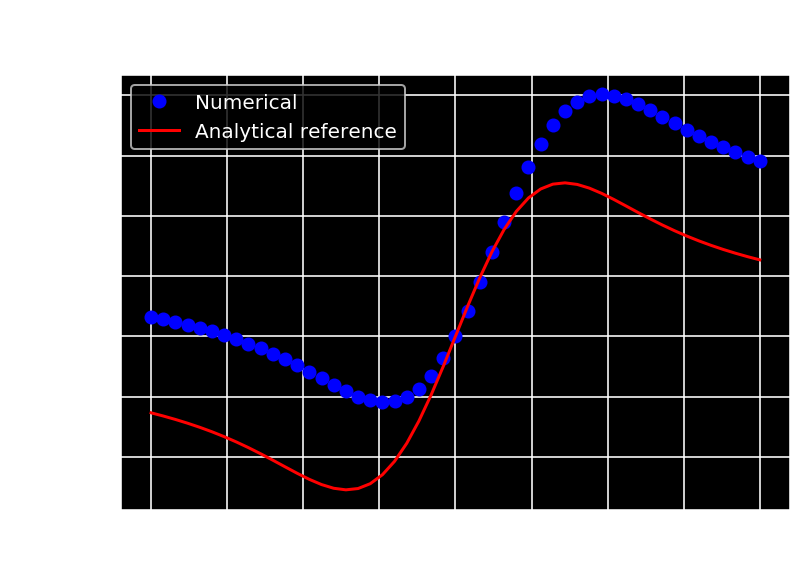

In [20]:
madx = Madx()
xma=0.00025
madx.input(
f'''
option,echo=false,warn=false,info=false;
myBB : beambeam, charge=1, sigx={sigma_x}, sigy={sigma_y}, xma={xma}, yma={yma}, bbshape=1, bbdir=-1;

lhc: sequence, l={positionBB};
myBB1: myBB, at={positionBB};
endsequence;

beam, particle=proton, energy={totalEnergy},npart={npart};

use, sequence=lhc;

option, bborbit=false;
twiss,betx={betax_IP},bety={betay_IP};
''');

trackIt()
plt.gca().set_title('BB Kick in a simple transfer line\n$xma$ = 0.25 mm - bborbit = False - onepass = False');

#plt.savefig('/eos/user/a/apoyet/localMac/PLOTS/bb_effect/simple_transfer_line_off_false_false.png', bbox_inches='tight')

In [21]:
twissDF()

x    y   px   py
#s          0.0  0.0  0.0  0.0
drift_0[0]  0.0  0.0  0.0  0.0
mybb1       0.0  0.0  0.0  0.0
#e          0.0  0.0  0.0  0.0

**WARNING**

In [25]:
madx = Madx()
xma=0.00025
madx.input(
f'''
option,echo=false,warn=false,info=false;
myBB : beambeam, charge=1, sigx={sigma_x}, sigy={sigma_y}, xma={xma}, yma={yma}, bbshape=1, bbdir=-1;

lhc: sequence, l={positionBB};
myBB1: myBB, at={positionBB};
endsequence;

beam, particle=proton, energy={totalEnergy},npart={npart};

use, sequence=lhc;

option, bborbit=true;
twiss,betx={betax_IP},bety={betay_IP};
''');


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.11.01 15:11:27      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00 -2.918340E-08  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       0.246021955                  0             400.25                  0 

             dxrms             xcomax             xcorms                 q2 
                 0         

enter TRACK module
  
iteration:   1 error:   2.918340E-08 deltap:   0.000000E+00
orbit:   2.943113E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   1 error:   2.918340E-08 deltap:   0.000000E+00
orbit:   2.943113E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

Full 6D closed orbit search.
Initial value of 6-D closed orbit from Twiss: 
orbit0   2.943113E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  Singular matrix occurred during closed orbit search.

6D closed orbit found by subroutine trclor 
iteration:   2 error:   5.569057E-08 deltap:   0.000000E+00
orbit:   2.943113E-04  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
exit TRACK module



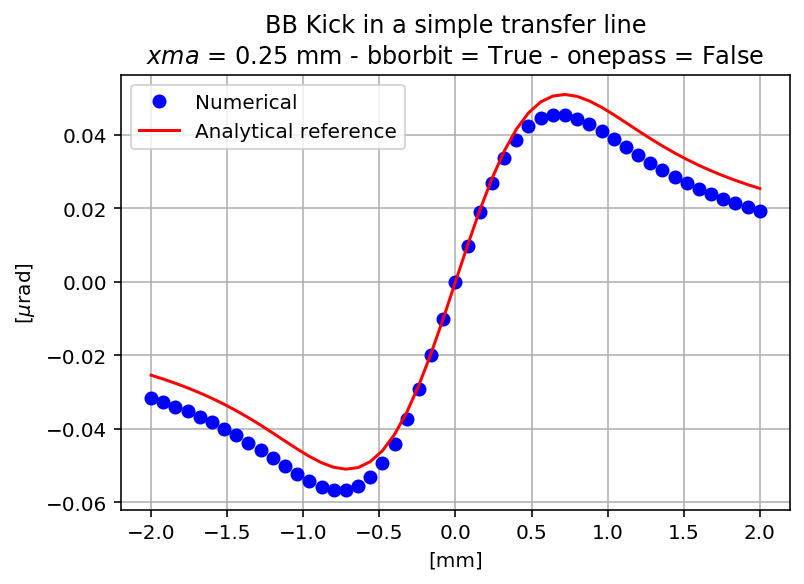

In [26]:
trackIt()
plt.gca().set_title('BB Kick in a simple transfer line\n$xma$ = 0.25 mm - bborbit = True - onepass = False');

plt.savefig('/eos/user/a/apoyet/localMac/PLOTS/bb_effect/simple_transfer_line_off_true_false.png', bbox_inches='tight')

But if we use *onepass='true'*. Note that the closed orbit is not computed during the tracking (**6D closed orbit found by subroutine trclor** not present in the output).

In [28]:
madx = Madx()
xma=0.00025
madx.input(
f'''
option,echo=false,warn=false,info=false;
myBB : beambeam, charge=1, sigx={sigma_x}, sigy={sigma_y}, xma={xma}, yma={yma}, bbshape=1, bbdir=-1;

lhc: sequence, l={positionBB};
myBB1: myBB, at={positionBB};
endsequence;

beam, particle=proton, energy={totalEnergy},npart={npart};

use, sequence=lhc;

option, bborbit=false;
twiss,betx={betax_IP},bety={betay_IP};
''');


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.11.01 16:09:37      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       0.246021955                  0             400.25                  0 

             dxrms             xcomax             xcorms                 q2 
                 0         

enter TRACK module
one pass is on
exit TRACK module



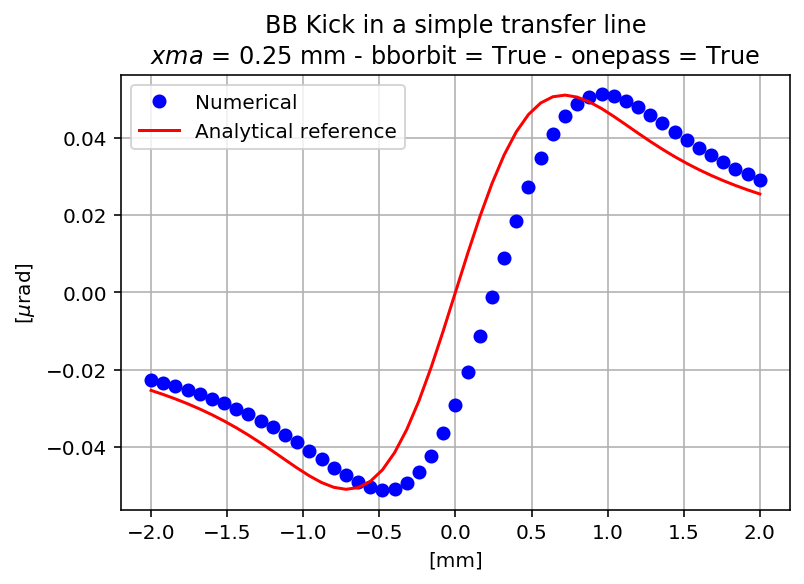

In [29]:
trackIt(onepass='true')
plt.gca().set_title('BB Kick in a simple transfer line\n$xma$ = 0.25 mm - bborbit = True - onepass = True');

plt.savefig('/eos/user/a/apoyet/localMac/PLOTS/bb_effect/simple_transfer_line_off_true_true.png', bbox_inches='tight')

With onepass='true' the bborbit flag is not relevant. Note that the closed orbit is not computed during the tracking.


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.10.30 18:37:09      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
open line - error with deltap:   0.000000E+00
initial orbit vector:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
final orbit vector:     0.000000E+00 -2.918340E-08  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
       0.246021955                  0             400.25                  0 

             dxrms             xcomax             xcorms                 q2 
                 0         

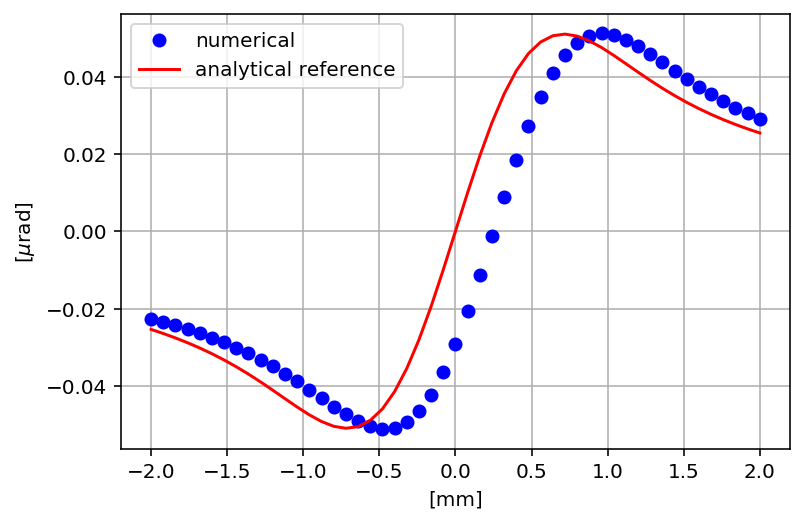

In [101]:
madx = Madx()
xma=0.00025
madx.input(
f'''
option,echo=false,warn=false,info=false;
myBB : beambeam, charge=1, sigx={sigma_x}, sigy={sigma_y}, xma={xma}, yma={yma}, bbshape=1, bbdir=-1;

lhc: sequence, l={positionBB};
myBB1: myBB, at={positionBB};
endsequence;

beam, particle=proton, energy={totalEnergy},npart={npart};

use, sequence=lhc;

option, bborbit=true;
twiss,betx={betax_IP},bety={betay_IP};
''');
trackIt(onepass='true')

# Second part
Let us close the machine with a linear matrix and repeat the analysis.

In [28]:
madx = Madx()

################################################################################################

xma = 0
betax1=betax_BB
betax2=betax_IP
alfx1=-positionBB/betax_IP
alfx2=0
mux12=.31-np.arctan(positionBB/betax_IP)/2/np.pi

RM11=np.sqrt(betax2/betax1)*(np.cos(2*np.pi*mux12)+alfx1*np.sin(2*np.pi*mux12))
RM12=np.sqrt(betax1*betax2)*np.sin(2*np.pi*mux12)
RM21=-(1+alfx1*alfx2)/np.sqrt(betax1*betax2)*np.sin(2*np.pi*mux12)+\
(alfx1-alfx2)/np.sqrt(betax1*betax2)*np.cos(2*np.pi*mux12)
RM22=np.sqrt(betax1/betax2)*(np.cos(2*np.pi*mux12)-alfx2*np.sin(2*np.pi*mux12))

betay1=betay_BB
betay2=betay_IP
alfy1=-positionBB/betay_IP
alfy2=0
muy12=.32-np.arctan(positionBB/betay_IP)/2/np.pi

RM33=np.sqrt(betay2/betay1)*(np.cos(2*np.pi*muy12)+alfy1*np.sin(2*np.pi*muy12))
RM34=np.sqrt(betay2*betay1)*np.sin(2*np.pi*muy12)
RM43=-(1+alfy1*alfy2)/np.sqrt(betay1*betay2)*np.sin(2*np.pi*muy12)+\
(alfy1-alfy2)/np.sqrt(betay1*betay2)*np.cos(2*np.pi*muy12)
RM44=np.sqrt(betay1/betay2)*(np.cos(2*np.pi*muy12)-alfy2*np.sin(2*np.pi*muy12))

################################################################################################


madx.input(
f'''

myBB : beambeam, charge=+1, sigx={sigma_x}, sigy={sigma_y}, xma={xma}, yma={yma}, bbshape=1, bbdir=-1;
myMatrix: MATRIX, L=0, RM11={RM11}, RM12={RM12}, RM21={RM21}, RM22={RM22},
    RM33={RM33}, RM34={RM34}, RM43={RM43}, RM44={RM44};
    
lhc: sequence, l={positionBB};
myBB1: myBB, at={positionBB};
myMatrix1: myMatrix, at={positionBB};
endsequence;

beam, particle=proton, energy={totalEnergy}, npart={npart};
use, sequence=lhc;

option, bborbit=false;
twiss;
option,echo=false,warn=false,info=false;
''');


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.11.03 18:46:28      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.3060066586       -3.148841555        396.4369155                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.3160103551 

               dq2            betymax              dymax 

enter TRACK module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

Full 6D closed orbit search.
Initial value of 6-D closed orbit from Twiss: 
orbit0   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  Singular matrix occurred during closed orbit search.

6D closed orbit found by subroutine trclor 
iteration:   2 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
exit TRACK module



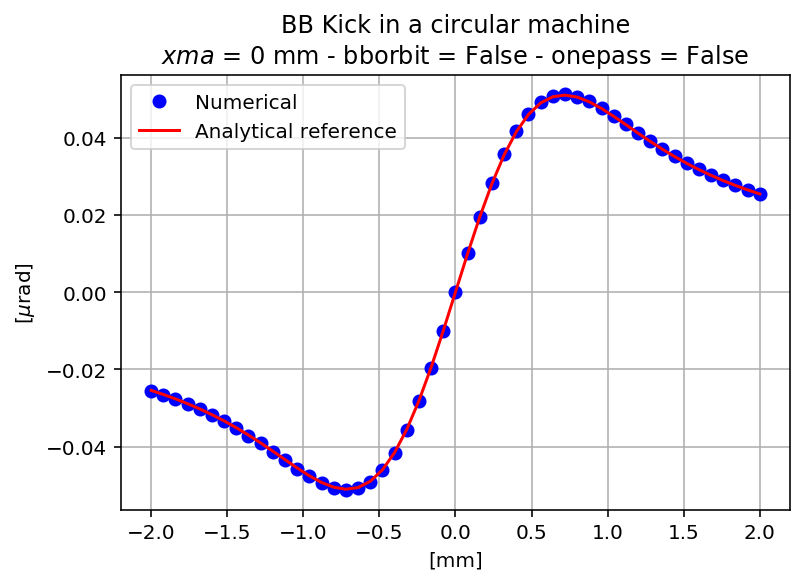

In [29]:
trackIt(onepass='false')

plt.gca().set_title('BB Kick in a circular machine\n$xma$ = 0 mm - bborbit = False - onepass = False');

plt.savefig('/eos/user/a/apoyet/localMac/PLOTS/bb_effect/circular_no_off_false_false.png', bbox_inches='tight')

In [30]:
madx.table.twiss.dframe()[['x','y']]

x    y
#s          0.0  0.0
drift_0[0]  0.0  0.0
mybb1       0.0  0.0
mymatrix1   0.0  0.0
#e          0.0  0.0

In [31]:
madx = Madx()

################################################################################################

xma = 0.00025
betax1=betax_BB
betax2=betax_IP
alfx1=-positionBB/betax_IP
alfx2=0
mux12=.31-np.arctan(positionBB/betax_IP)/2/np.pi

RM11=np.sqrt(betax2/betax1)*(np.cos(2*np.pi*mux12)+alfx1*np.sin(2*np.pi*mux12))
RM12=np.sqrt(betax1*betax2)*np.sin(2*np.pi*mux12)
RM21=-(1+alfx1*alfx2)/np.sqrt(betax1*betax2)*np.sin(2*np.pi*mux12)+\
(alfx1-alfx2)/np.sqrt(betax1*betax2)*np.cos(2*np.pi*mux12)
RM22=np.sqrt(betax1/betax2)*(np.cos(2*np.pi*mux12)-alfx2*np.sin(2*np.pi*mux12))

betay1=betay_BB
betay2=betay_IP
alfy1=-positionBB/betay_IP
alfy2=0
muy12=.32-np.arctan(positionBB/betay_IP)/2/np.pi

RM33=np.sqrt(betay2/betay1)*(np.cos(2*np.pi*muy12)+alfy1*np.sin(2*np.pi*muy12))
RM34=np.sqrt(betay2*betay1)*np.sin(2*np.pi*muy12)
RM43=-(1+alfy1*alfy2)/np.sqrt(betay1*betay2)*np.sin(2*np.pi*muy12)+\
(alfy1-alfy2)/np.sqrt(betay1*betay2)*np.cos(2*np.pi*muy12)
RM44=np.sqrt(betay1/betay2)*(np.cos(2*np.pi*muy12)-alfy2*np.sin(2*np.pi*muy12))

################################################################################################


madx.input(
f'''

myBB : beambeam, charge=+1, sigx={sigma_x}, sigy={sigma_y}, xma={xma}, yma={yma}, bbshape=1, bbdir=-1;
myMatrix: MATRIX, L=0, RM11={RM11}, RM12={RM12}, RM21={RM21}, RM22={RM22},
    RM33={RM33}, RM34={RM34}, RM43={RM43}, RM44={RM44};
    
lhc: sequence, l={positionBB};
myBB1: myBB, at={positionBB};
myMatrix1: myMatrix, at={positionBB};
endsequence;

beam, particle=proton, energy={totalEnergy}, npart={npart};
use, sequence=lhc;

option, bborbit=false;
twiss;
option,echo=false,warn=false,info=false;
''');


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.11.03 18:46:54      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0                  0                  0 

                q1                dq1            betxmax              dxmax 
      0.3068538274       -3.155891822        397.2188984                  0 

             dxrms             xcomax             xcorms                 q2 
                 0                  0                  0       0.3163018159 

               dq2            betymax              dymax 

enter TRACK module
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   1 error:   0.000000E+00 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

Full 6D closed orbit search.
Initial value of 6-D closed orbit from Twiss: 
orbit0   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  Singular matrix occurred during closed orbit search.

6D closed orbit found by subroutine trclor 
iteration:   2 error:   7.811467E-07 deltap:   0.000000E+00
orbit:   0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
exit TRACK module



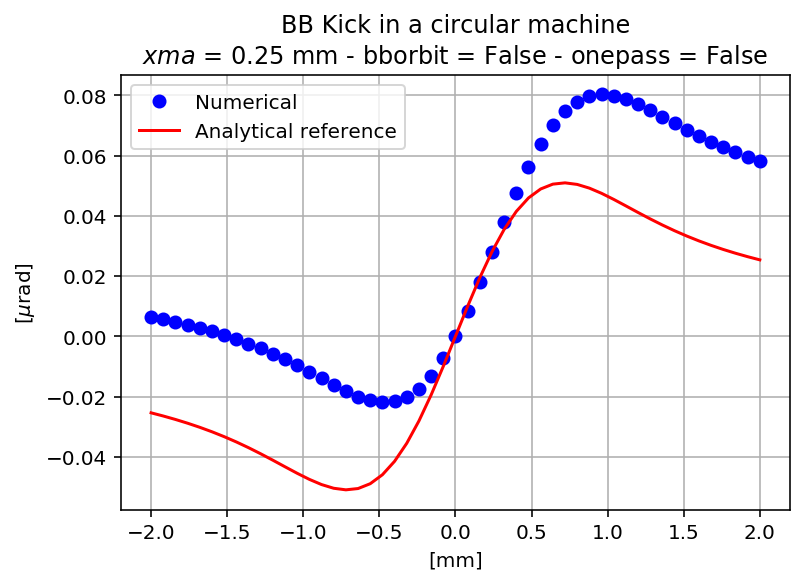

In [32]:
trackIt(onepass='false')

plt.gca().set_title('BB Kick in a circular machine\n$xma$ = 0.25 mm - bborbit = False - onepass = False');

plt.savefig('/eos/user/a/apoyet/localMac/PLOTS/bb_effect/circular_off_false_false.png', bbox_inches='tight')

In [33]:
madx.table.twiss.dframe()[['x','y']]

x    y
#s          0.0  0.0
drift_0[0]  0.0  0.0
mybb1       0.0  0.0
mymatrix1   0.0  0.0
#e          0.0  0.0

Note the the CO (TWISS summary) is vanishing. The bborbit=false removed the dipolar kick.
If you put bborbit=true the CO is not vanisching any more (see below) but the tracking (done with respect to the CO) is identical to the one of the previous cell.

In [36]:
madx = Madx()

################################################################################################

betax1=betax_BB
betax2=betax_IP
alfx1=-positionBB/betax_IP
alfx2=0
mux12=.31-np.arctan(positionBB/2/betax_IP)/2/np.pi

RM11=np.sqrt(betax2/betax1)*(np.cos(2*np.pi*mux12)+alfx1*np.sin(2*np.pi*mux12))
RM12=np.sqrt(betax1*betax2)*np.sin(2*np.pi*mux12)
RM21=-(1+alfx1*alfx2)/np.sqrt(betax1*betax2)*np.sin(2*np.pi*mux12)+\
(alfx1-alfx2)/np.sqrt(betax1*betax2)*np.cos(2*np.pi*mux12)
RM22=np.sqrt(betax1/betax2)*(np.cos(2*np.pi*mux12)-alfx2*np.sin(2*np.pi*mux12))

betay1=betay_BB
betay2=betay_IP
alfy1=-positionBB/betay_IP
alfy2=0
muy12=.32-np.arctan(positionBB/2/betay_IP)/2/np.pi

RM33=np.sqrt(betay2/betay1)*(np.cos(2*np.pi*muy12)+alfy1*np.sin(2*np.pi*muy12))
RM34=np.sqrt(betay2*betay1)*np.sin(2*np.pi*muy12)
RM43=-(1+alfy1*alfy2)/np.sqrt(betay1*betay2)*np.sin(2*np.pi*muy12)+\
(alfy1-alfy2)/np.sqrt(betay1*betay2)*np.cos(2*np.pi*muy12)
RM44=np.sqrt(betay1/betay2)*(np.cos(2*np.pi*muy12)-alfy2*np.sin(2*np.pi*muy12))

################################################################################################


madx.input(
f'''

myBB : beambeam, charge=+1, sigx={sigma_x}, sigy={sigma_y}, xma={xma}, yma={yma}, bbshape=1, bbdir=-1;
myMatrix: MATRIX, L=0, RM11={RM11}, RM12={RM12}, RM21={RM21}, RM22={RM22},
    RM33={RM33}, RM34={RM34}, RM43={RM43}, RM44={RM44};
    
lhc: sequence, l={positionBB};
myBB1: myBB, at={positionBB};
myMatrix1: myMatrix, at={positionBB};
endsequence;

beam, particle=proton, energy={totalEnergy}, npart={npart};
use, sequence=lhc;

option, bborbit=true;
twiss;
option,echo=false,warn=false,info=false;
''');


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.05.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2019.06.07               +
  + Execution date: 2019.11.03 18:54:45      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
iteration:   1 error:   1.062880E-06 deltap:   0.000000E+00
orbit:  -1.503032E-07 -3.764494E-07  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   5.505604E-11 deltap:   0.000000E+00
orbit:  -1.502954E-07 -3.764299E-07  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
                10                 -0    1.897589662e-12        725936.8575 

                q1                dq1            betxmax              dxmax 
       0.310852246        -3.15401059        397.0171297    4.855229865e-05 

             dxrms             xcomax             xcorms 

enter TRACK module
  
iteration:   1 error:   1.062880E-06 deltap:   0.000000E+00
orbit:  -1.503032E-07 -3.764494E-07  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   5.505604E-11 deltap:   0.000000E+00
orbit:  -1.502954E-07 -3.764299E-07  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   1 error:   1.062880E-06 deltap:   0.000000E+00
orbit:  -1.503032E-07 -3.764494E-07  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  
iteration:   2 error:   5.505604E-11 deltap:   0.000000E+00
orbit:  -1.502954E-07 -3.764299E-07  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00

Full 6D closed orbit search.
Initial value of 6-D closed orbit from Twiss: 
orbit0  -1.502954E-07 -3.764299E-07  0.000000E+00  0.000000E+00  0.000000E+00  0.000000E+00
  Singular matrix occurred during closed orbit search.

6D closed orbit found by subroutine trclor 
iteration:   2 error:   7.087664E-13 deltap:   0.000000E+00
orbit:  -1.502954E-07 -3.764299E

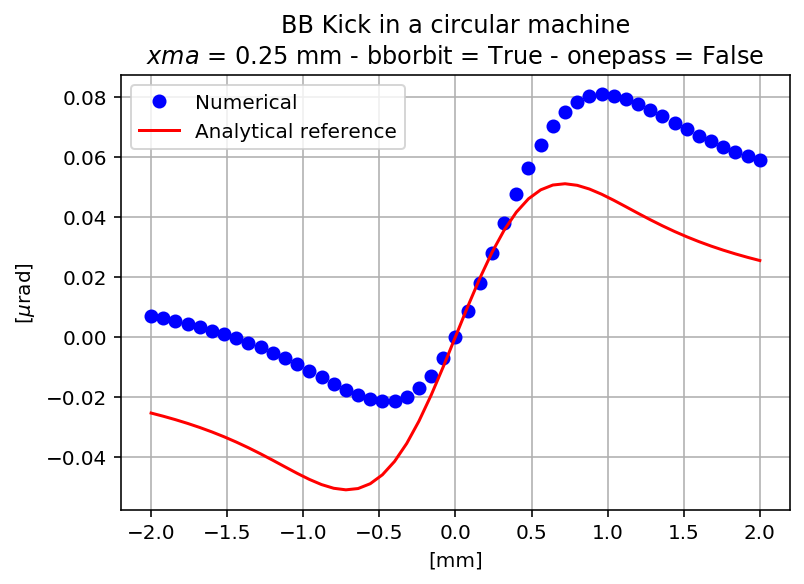

In [37]:
trackIt(onepass='false')
plt.gca().set_title('BB Kick in a circular machine\n$xma$ = 0.25 mm - bborbit = True - onepass = False');

plt.savefig('/eos/user/a/apoyet/localMac/PLOTS/bb_effect/circular_off_true_false.png', bbox_inches='tight')

In [38]:
madx.table.twiss.dframe()[['x','y']]

x    y
#s         -1.502954e-07  0.0
drift_0[0] -3.914595e-06  0.0
mybb1      -3.914595e-06  0.0
mymatrix1  -1.502954e-07  0.0
#e         -1.502954e-07  0.0

CONCLUSIONS: Axel will do it so I can check how clear the notebook was.

enter TRACK module
one pass is on
exit TRACK module



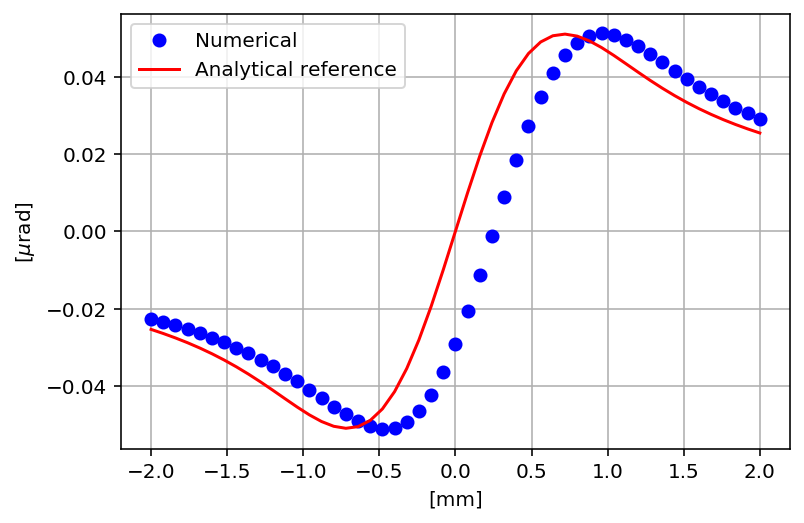

In [27]:
trackIt(onepass='true')